# Del 1

#### 1. Beskriv kort hur en relationsdatabas fungerar

En relationsdatabas där man kan lagra data i tabeller som är relaterade till varandra med hjälp av primärnycklar (som är unika för varje rad) och främmande nycklar (som skapar förhållanden mellan tabeller). På så sätt kan man skapa små tabeller och därmed reducera redundans och komplexiteten. Man använder SQL för att interagera med en sådan databas.

#### 2. Vad menas med “CRUD”-flödet?

CRUD står för Create (lägga till information), Read (läsa), Update (uppdatera) och Delete (radera). Det är de fyra grundläggande operationerna som man ska kunna utföra på data i en relationsdatabas.

#### 3. Beskriv kort vad en “left join” och en “inner join” är. Varför använder man det?

En left join hämtar alla rader från den första tabellen och alla rader från den andra tabellen som har ett matchande värde i den första tabellen. En inner join däremot hämtar BARA rader från den första tabellen som har ett matchande värde i den andra tabellen. Man använder det för att kunna kombinera data från två tabeller baserat på ett gemensamt fält.

#### 4. Beskriv kort vad indexering i SQL innebär.

Indexering används för att snabba upp sökningar i en db. Ett index skapas på en eller flera kolumner för att göra det enklare att hitta specifika rader utan att behöva söka igenom hela tabellen.

#### 6. Beskriv kort vad en vy i SQL är.

En vy i SQL är som en låtsastabell som visar data från en eller flera tabeller. Den gör det lättare att arbeta med data utan att ändra något i de riktiga tabellerna.

#### 7. Beskriv kort vad en lagrad procedur i SQL är.
En lagrad procedur i SQL är ett sparat program i SQL-kod som kan köras när som helst för att utföra en uppgift i DB.


In [84]:
#!pip install sqlalchemy pandas tabulate matplotlib ipykernel jupyter notebook pyodbc scipy seaborn

In [1]:
import pyodbc
from sqlalchemy import create_engine

# Create connection string
conn_str = (
    'DRIVER={SQL Server};'
    'SERVER=OMEN;'
    'DATABASE=AdventureWorks2022;'
    'Trusted_Connection=yes;'
)

# Create SQLAlchemy engine
engine = create_engine(f'mssql+pyodbc:///?odbc_connect={conn_str}')

# Create pyodbc connection
aw = pyodbc.connect(conn_str)

#### Först utforskar jag strukturen av db AdventureWorks2022


In [3]:
import pandas as pd

query = """SELECT * 
FROM INFORMATION_SCHEMA.TABLES;"""
df = pd.read_sql(query, engine)
print(df.to_markdown())


|    | TABLE_CATALOG      | TABLE_SCHEMA   | TABLE_NAME                            | TABLE_TYPE   |
|---:|:-------------------|:---------------|:--------------------------------------|:-------------|
|  0 | AdventureWorks2022 | Sales          | SalesTaxRate                          | BASE TABLE   |
|  1 | AdventureWorks2022 | Sales          | PersonCreditCard                      | BASE TABLE   |
|  2 | AdventureWorks2022 | Person         | vAdditionalContactInfo                | VIEW         |
|  3 | AdventureWorks2022 | Person         | PersonPhone                           | BASE TABLE   |
|  4 | AdventureWorks2022 | HumanResources | vEmployee                             | VIEW         |
|  5 | AdventureWorks2022 | Sales          | SalesTerritory                        | BASE TABLE   |
|  6 | AdventureWorks2022 | HumanResources | vEmployeeDepartment                   | VIEW         |
|  7 | AdventureWorks2022 | Person         | PhoneNumberType                       | BASE TABLE   |


#### Det finns 92 tabeller och vyer i db:n som är uppdelade i scheman. Base tabeller är de som innehåller data. Det som vi är intresserade av är de 5 scheman nämligen humanresources, production, sales, person och purchasing.

#### Vilka är de som jobbar på företaget?

In [66]:
query = """
SELECT COUNT(*) AS TotalEmployees
FROM HumanResources.Employee;
"""
df1 = pd.read_sql(query, engine)
print(df1)


query = """
SELECT 
    A.FirstName,
    A.LastName, 
    B.JobTitle
FROM Person.Person A
JOIN HumanResources.Employee B
ON A.BusinessEntityID = B.BusinessEntityID
WHERE B.JobTitle = 'Chief Executive Officer';
"""
df2 = pd.read_sql(query, engine)
print(df2)


   TotalEmployees
0             290
  FirstName LastName                 JobTitle
0       Ken  Sánchez  Chief Executive Officer


Ken Sánchez  [https://www.linkedin.com/in/ken-sanchez-1755867a/]


#### vi kan analysera kunddata
#### t.ex. skapa ett stapeldiagram för antal kunder per territorium

|    | Name           |   CC |
|---:|:---------------|-----:|
|  0 | Southwest      | 4696 |
|  1 | Australia      | 3665 |
|  2 | Northwest      | 3520 |
|  3 | United Kingdom | 1991 |
|  4 | France         | 1884 |
|  5 | Germany        | 1852 |
|  6 | Canada         | 1791 |
|  7 | Southeast      |  176 |
|  8 | Central        |  132 |
|  9 | Northeast      |  113 |


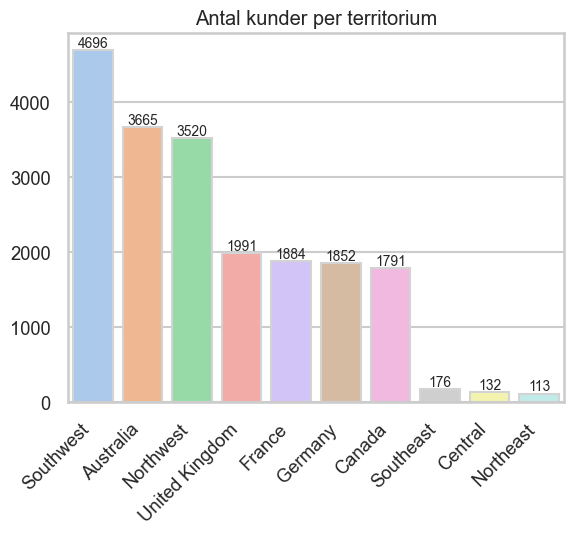

In [24]:

import seaborn as sns
import matplotlib.pyplot as plt

query = """
SELECT 
    B.Name,
    COUNT(*) AS CC
FROM sales.customer A
LEFT JOIN sales.SalesTerritory B
ON A.TerritoryID = B.TerritoryID
GROUP BY B.Name
ORDER BY CC DESC;
"""
df = pd.read_sql(query, engine)
print(df.to_markdown())


plt.figure()
bar_plot = sns.barplot(x='Name', y='CC', data=df, palette="pastel", hue='Name', edgecolor='lightgray')

plt.xlabel(''), plt.ylabel(''), plt.title('Antal kunder per territorium'), plt.xticks(rotation=45, ha='right')

#text over
for index, row in df.iterrows():
    plt.text(row.name, row.CC, row.CC, ha='center', va='bottom', fontsize=10)


plt.show()


#### De flesta kunder kommer från Southwest i USA. Det är kanske där vi ska anlägga vår nya fabrik.

#### Jag vet fortfarande inte vad företaget säljer.
#### Därför ska jag skapa ett cirkeldiagram för produktkategorier

|    | Name        |   C |
|---:|:------------|----:|
|  0 | Accessories |   8 |
|  1 | Bikes       |  32 |
|  2 | Clothing    |  22 |
|  3 | Components  |  43 |


Text(0.5, 1.0, 'Product Categories')

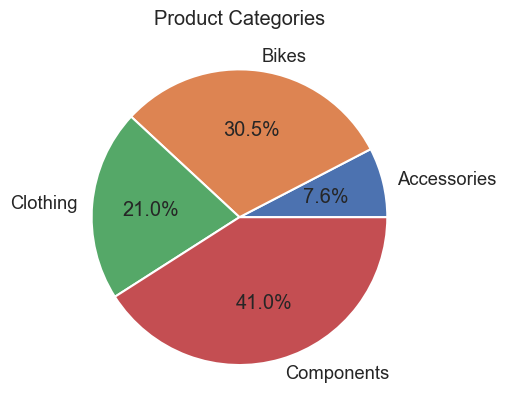

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

query = """
SELECT A.Name, COUNT(*) AS C
FROM production.product B
JOIN production.ProductCategory A
ON B.ProductSubcategoryID = A.ProductCategoryID 
GROUP BY A.Name
"""
df = pd.read_sql(query, engine)
print(df.to_markdown())

plt.pie(x=df['C'], labels=df['Name'], autopct='%1.1f%%')
plt.title('Product Categories')


#### Bikes och Components är de produktkategorier som företaget fokuserar mest på. Lite mindre på kläder och accessories.


#### hur mycket känner företaget per år? 
#### det går att visualisera försäljningen över tid med hjälp av en linjediagram men också andra diagram t.ex. ett stapeldiagram


   Year    TotalSales
0  2011  1.264167e+07
1  2012  3.352430e+07
2  2013  4.362248e+07
3  2014  2.005793e+07


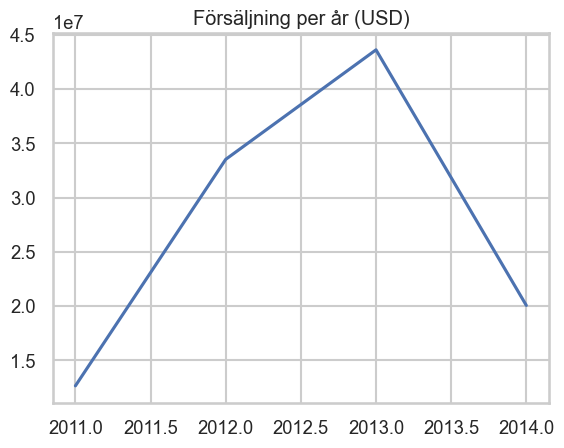

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

query = """ SELECT 
    YEAR(OrderDate) AS Year, 
    SUM(SubTotal) AS TotalSales
FROM sales.salesorderheader

GROUP BY YEAR(OrderDate)
ORDER BY Year;
"""
df = pd.read_sql(query, engine)
print(df)

plt.plot(df['Year'], df['TotalSales'])
plt.title('Försäljning per år (USD)')
#plt.xticks(df['Year'])
plt.show()



### år 2013 sålde företaget för mer än 40 miljoner USD. Det är nästan 400% ökning jämfört med år 2012. Men år 2014 var försäljningen halverad. Kanske något som vi bör undersöka mer senare, i andra delen av uppgiften då vi ska göra statistisk analys på försäljningen under 2014.

# Del 2


#### Nu tänker jag med hjälp av statistisk analys undersöka varför försäljningen sjönk under 2014.

#### En möjlig orsak kan vara att försäljningen minskade på grund av pricerna på produkterna blev för höga under år 2014 så kunderna valde en konkurrent istället.

#### Jag börjar med att hämta alla produkter som lanserades under 2013.

In [71]:
query = """
SELECT
    A.ProductID,
    B.Name,
    A.StartDate
FROM 
    Production.ProductListPriceHistory A 
    JOIN Production.Product B
    ON A.ProductID = B.ProductID
WHERE 
    YEAR(A.StartDate) = 2013;
"""
sales_df = pd.read_sql(query, engine)
sales_df


,ProductID,Name,StartDate
0,707,"Sport-100 Helmet, Red",2013-05-30
1,708,"Sport-100 Helmet, Black",2013-05-30
2,711,"Sport-100 Helmet, Blue",2013-05-30
3,712,AWC Logo Cap,2013-05-30
4,713,"Long-Sleeve Logo Jersey, S",2013-05-30
...,...,...,...
190,995,ML Bottom Bracket,2013-05-30
191,996,HL Bottom Bracket,2013-05-30
192,997,"Road-750 Black, 44",2013-05-30
193,998,"Road-750 Black, 48",2013-05-30


#### Nu vill jag hämta alla produkter som lanserades under år 2014.

In [73]:

query = """
SELECT 
    A.ProductID,
    B.Name,
    A.StartDate
FROM 
    Production.ProductListPriceHistory A
    JOIN Production.Product B
    ON A.ProductID = B.ProductID
WHERE 
    YEAR(A.StartDate) = 2014;
"""

df = pd.read_sql(query, engine)
df



,ProductID,Name,StartDate


#### Jag kan inte komma vidare då företaget inte lanserade nya produkter under 2014 vilket kan vara en anledning till den stora försäljningsnedgången.

#### Men jag kan ändå analysera om det fanns skillnader i antalet sålda enheter för produkter mellan 2013 och 2014. Dvs att antalet sålda enheter av varje produkt minskade år 2014 respektive år 2013.

#### Jag började med att hämta data om försäljningen för alla produkter under 2013 och sorterade dem efter antalet sålda enheter. Därefter sparade jag **ProductID** i en lista för att jämföra antalet sålda enheter för samma produkter mellan de två åren och testa min hypotes.

In [126]:
query = """
SELECT
    A.ProductID, 
    B.Name,
    SUM(A.Quantity) AS TotalSold_2013
FROM 
    Production.TransactionHistory A
INNER JOIN 
    Production.Product B
    ON A.ProductID = B.ProductID
WHERE 
    YEAR(A.TransactionDate) = 2013 AND A.TransactionType = 'S' -- Sales, "W" står för "Withdrawal"
GROUP BY 
    A.ProductID, B.Name
ORDER BY 
    TotalSold_2013 DESC;
"""
sales_df = pd.read_sql(query, engine)


product_ids = sales_df['ProductID'].tolist()  
sales_df


,ProductID,Name,TotalSold_2013
0,870,Water Bottle - 30 oz.,2918
1,712,AWC Logo Cap,2183
2,864,"Classic Vest, S",2006
3,708,"Sport-100 Helmet, Black",1893
4,711,"Sport-100 Helmet, Blue",1832
...,...,...,...
194,843,Cable Lock,1
195,726,"LL Road Frame - Red, 48",1
196,826,LL Road Rear Wheel,1
197,763,"Road-650 Red, 48",1


In [127]:
query_2014 = f"""
SELECT 
    ProductID,
    SUM(Quantity) AS TotalSold_2014
FROM 
    Production.TransactionHistory
WHERE 
    YEAR(TransactionDate) = 2014 
    AND TransactionType = 'S' -- Sales transactions
    AND ProductID IN ({', '.join(map(str, product_ids))}) -- fick hjälp av chatbot för att få detta att fungera. Join och map är funktioner som gör att jag kan använda product_ids i min query.
GROUP BY 
    ProductID
ORDER BY 
    TotalSold_2014 DESC;
"""
sales_2014_df = pd.read_sql(query_2014, engine)
sales_2014_df


,ProductID,TotalSold_2014
0,870,2902
1,712,1950
2,711,1776
3,873,1761
4,707,1717
...,...,...
173,761,2
174,861,2
175,726,1
176,765,1


#### merge är en funktion som kommer från pandas och gör att jag kan slå ihop dataframerna på ProductID.

In [128]:
combined_df = sales_df.merge(sales_2014_df, on='ProductID', how='left')

print(combined_df.head().to_markdown())

|    |   ProductID | Name                    |   TotalSold_2013 |   TotalSold_2014 |
|---:|------------:|:------------------------|-----------------:|-----------------:|
|  0 |         870 | Water Bottle - 30 oz.   |             2918 |             2902 |
|  1 |         712 | AWC Logo Cap            |             2183 |             1950 |
|  2 |         864 | Classic Vest, S         |             2006 |             1395 |
|  3 |         708 | Sport-100 Helmet, Black |             1893 |             1716 |
|  4 |         711 | Sport-100 Helmet, Blue  |             1832 |             1776 |


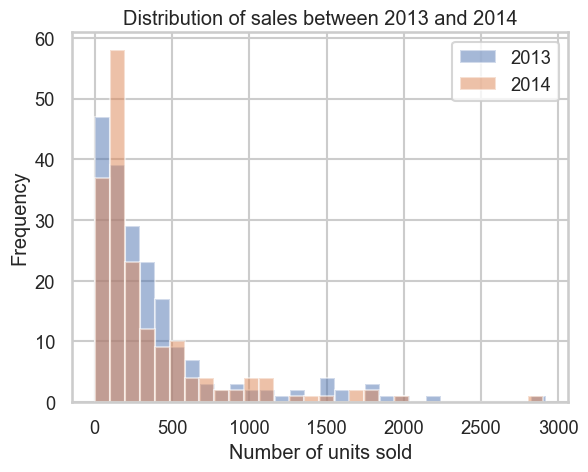

In [129]:
import matplotlib.pyplot as plt

# Plot distribution
plt.hist(combined_df['TotalSold_2013'], bins=30, alpha=0.5, label='2013') # Number of bins determines the intervals for data grouping
plt.hist(combined_df['TotalSold_2014'], bins=30, alpha=0.5, label='2014')
plt.xlabel('Number of units sold')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of sales between 2013 and 2014')
plt.show()


#### Histogrammet visar att de flesta produkter såldes i små volymer både 2013 och 2014, men 2014 dominerades ännu mer av låga försäljningsvolymer. Samtidigt sålde några få produkter mycket, vilket ger en högerskev fördelning med en lång svans åt höger. Det går inte att analysera datan med traditionella statistiska tester, eftersom de förutsätter en normalfördelad data. En log-transformering kan minska effekten av de extremt höga försäljningsvärdena.

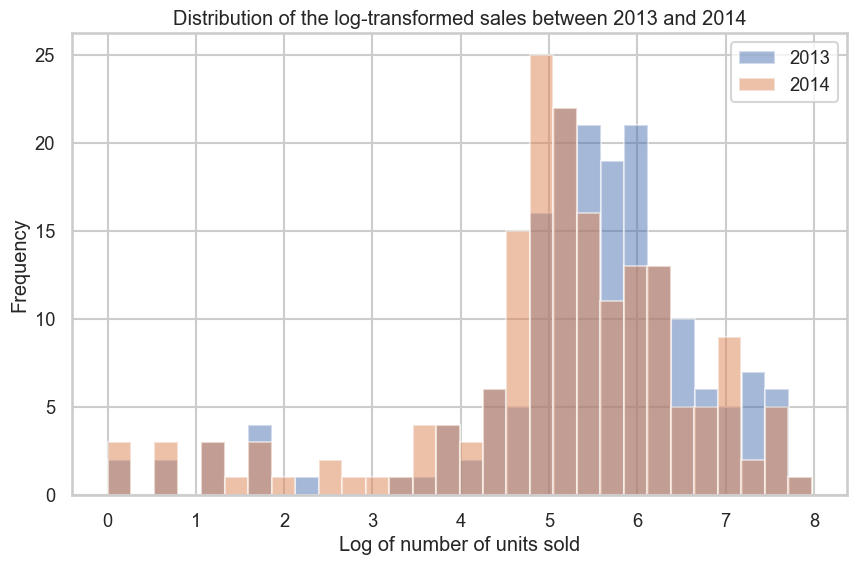

In [130]:
import numpy as np

# Filter out rows with zero or negative sales before log transformation
combined_df = combined_df[(combined_df['TotalSold_2013'] > 0) & (combined_df['TotalSold_2014'] > 0)]

# Log transform the filtered data
combined_df['TotalSold_2013_log'] = np.log(combined_df['TotalSold_2013'])
combined_df['TotalSold_2014_log'] = np.log(combined_df['TotalSold_2014'])

# Plot distribution of log-transformed data
plt.figure(figsize=(10, 6))
plt.hist(combined_df['TotalSold_2013_log'], bins=30, alpha=0.5, label='2013')
plt.hist(combined_df['TotalSold_2014_log'], bins=30, alpha=0.5, label='2014')

plt.xlabel('Log of number of units sold')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of the log-transformed sales between 2013 and 2014')

plt.show()


In [134]:
import numpy as np
import scipy.stats as stats

# Hämta data
x1, x2 = combined_df['TotalSold_2013_log'], combined_df['TotalSold_2014_log']

mean1, mean2 = x1.mean(), x2.mean()
# Varians
var1, var2 = x1.var(ddof=0), x2.var(ddof=0)  # ddof=0 för populationsvarians
n1, n2 = len(x1), len(x2)

print(f"{var1:.2f}")
print(f"{var2:.2f}")

2.10
2.42


In [138]:
# Standard error
SE = np.sqrt(var1/n1 + var2/n2)
# Konfidensintervall
mean_diff = mean1 - mean2

print(f"95% Konfidensintervall: [{mean_diff - 1.645 * SE:.2f}, {mean_diff + 1.645 * SE:.2f}]")

95% Konfidensintervall: [0.08, 0.60]


#### Försäljningen av produktenheter var signifikant högre 2013 än 2014 (med 95 % konfidens).

# Del 3.

### Executive Summary

År 2013 gick försäljningen riktigt bra och landade på över 40 miljoner USD. Men 2014 halverades den, troligen för att företaget inte lanserade några nya produkter, vilket gjorde att de tappade fart. Försäljningsdatan visar att de flesta produkter såldes i små mängder, medan några få sålde mycket mer. Till exempel sålde billigare grejer som **water bottles** och **logo caps** riktigt bra, medan dyrare produkter som cyklar och cykeldelar såldes i mindre volymer båda åren.

Försäljningen av produktenheter var signifikant högre 2013 än 2014 (med 95 % konfidens). För att bättre förstå varför vinsten sjönk 2014 skulle det vara intressant att kolla på globala trender det året, eftersom externa faktorer kan ha påverkat hur kunder handlade.

Företaget kan öka sin försäljning genom att satsa på populära och billiga produkter som **Logo Cap** och **Long-Sleeve Logo Jersey**, eftersom profilkläder verkar vara efterfrågade. Att lansera nya produkter regelbundet är också avgörande för att hålla kunderna intresserade. Ett lager i **Southwest USA** skulle vara en smart investering, eftersom många kunder bor där. Det skulle göra logistiken enklare och leveranstiderna kortare.

## Muntlig presentation: Den 3 januari 2025.

Jag hoppade över självutvärderingen. *